# Load libraries

In [22]:
import numpy as np
import pandas as pd 
import os
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense,Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

print("Load Models")

Load Models


# Data Preprocessing

In [23]:
class DataPreprocessing:
    
    def readData(path):
        filepaths = []
        labels = []

        folds = os.listdir(path)
        for fold in folds:
            foldpaths = os.path.join(path,fold)
            filelists = os.listdir(foldpaths)
            
            for file in filelists:
                filepath = os.path.join(foldpaths,file)
                
                filepaths.append(filepath)
                labels.append(fold)
                
        Fseries = pd.Series(filepaths, name="filepath")
        Lseries = pd.Series(labels, name="label")
        
        df = pd.concat([Fseries, Lseries], axis=1)
        
        return df

    def CreateImageDataGenerator(train_df, valid_df, test_df):
        image_size = (224, 224)
        batch_size = 20

        # Create an ImageDataGenerator for training with data augmentation
        train_gen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        ).flow_from_dataframe(train_df, x_col="filepath", y_col="label", color_mode='rgb',
                              class_mode="categorical", batch_size=batch_size, target_size=image_size)

        # Create an ImageDataGenerator for validation and test without augmentation
        valid_gen = ImageDataGenerator().flow_from_dataframe(valid_df, x_col="filepath", y_col="label", color_mode='rgb',
                                                              class_mode="categorical", batch_size=batch_size, target_size=image_size)

        test_gen = ImageDataGenerator().flow_from_dataframe(test_df, x_col="filepath", y_col="label", color_mode='rgb',
                                                             class_mode="categorical", batch_size=batch_size, target_size=image_size)

        return train_gen, valid_gen, test_gen

    
    def show_sample_of_data(data_gen):
        gen_dict = data_gen.class_indices
        classes_name = list(gen_dict.keys())

        images, labels = next(train_gen)


        plt.figure(figsize= (20, 20))

        for i in range(16):
            plt.subplot(4, 4, i + 1)
            image = images[i] / 255       # scales data to range (0 - 255)
            plt.imshow(image)
            index = np.argmax(labels[i])  # get image index
            class_name = classes_name[index]   # get class of image
            plt.title(class_name, color= 'blue', fontsize= 20)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
          

## Read the data frame

In [24]:
train_df = DataPreprocessing.readData("/kaggle/input/cards-image-datasetclassification/train")
train_df.head()

filepath          label
0  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
1  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
2  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
3  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
4  /kaggle/input/cards-image-datasetclassificatio...  ace of spades

In [25]:
valid_df = DataPreprocessing.readData("/kaggle/input/cards-image-datasetclassification/valid")
valid_df.head()

filepath          label
0  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
1  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
2  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
3  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
4  /kaggle/input/cards-image-datasetclassificatio...  ace of spades

In [26]:
test_df = DataPreprocessing.readData("/kaggle/input/cards-image-datasetclassification/test")
test_df.head()

filepath          label
0  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
1  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
2  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
3  /kaggle/input/cards-image-datasetclassificatio...  ace of spades
4  /kaggle/input/cards-image-datasetclassificatio...  ace of spades

## Create Image Data Generator

In [27]:
train_gen, valid_gen, test_gen = DataPreprocessing.CreateImageDataGenerator(train_df,valid_df,test_df)

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


## Show sample of train data

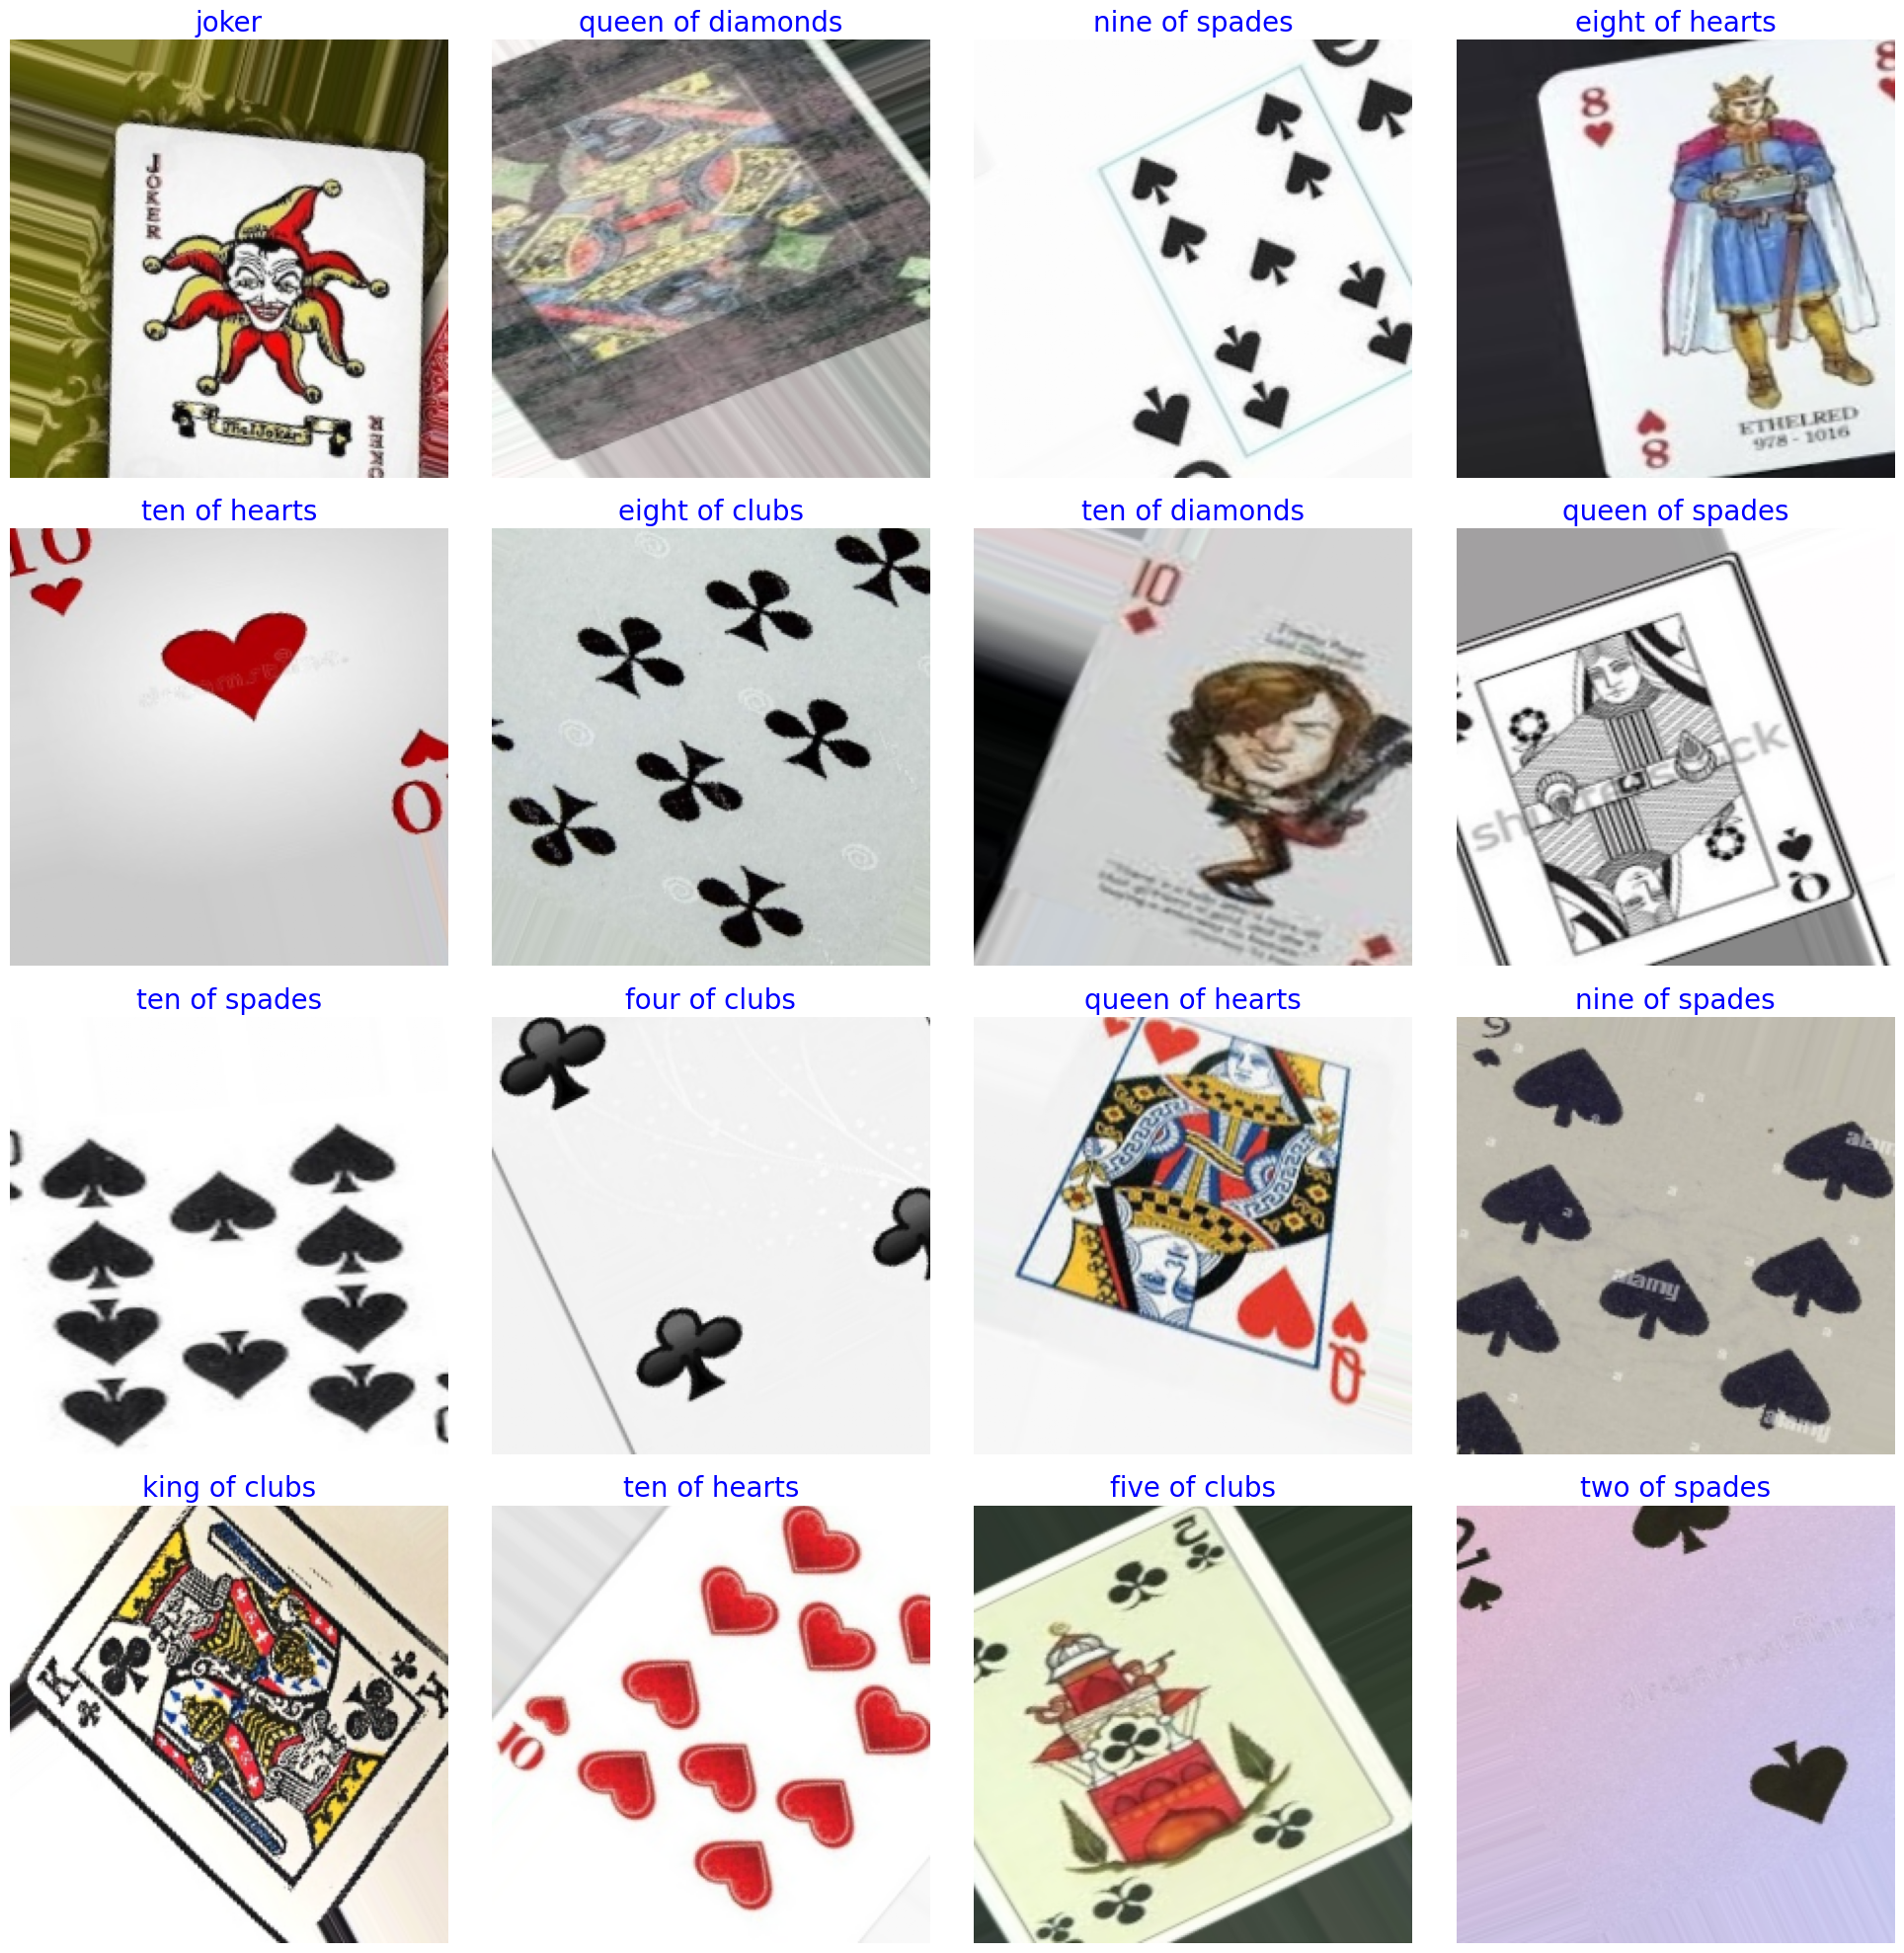

In [28]:
DataPreprocessing.show_sample_of_data(train_gen)

## Show sample of test data

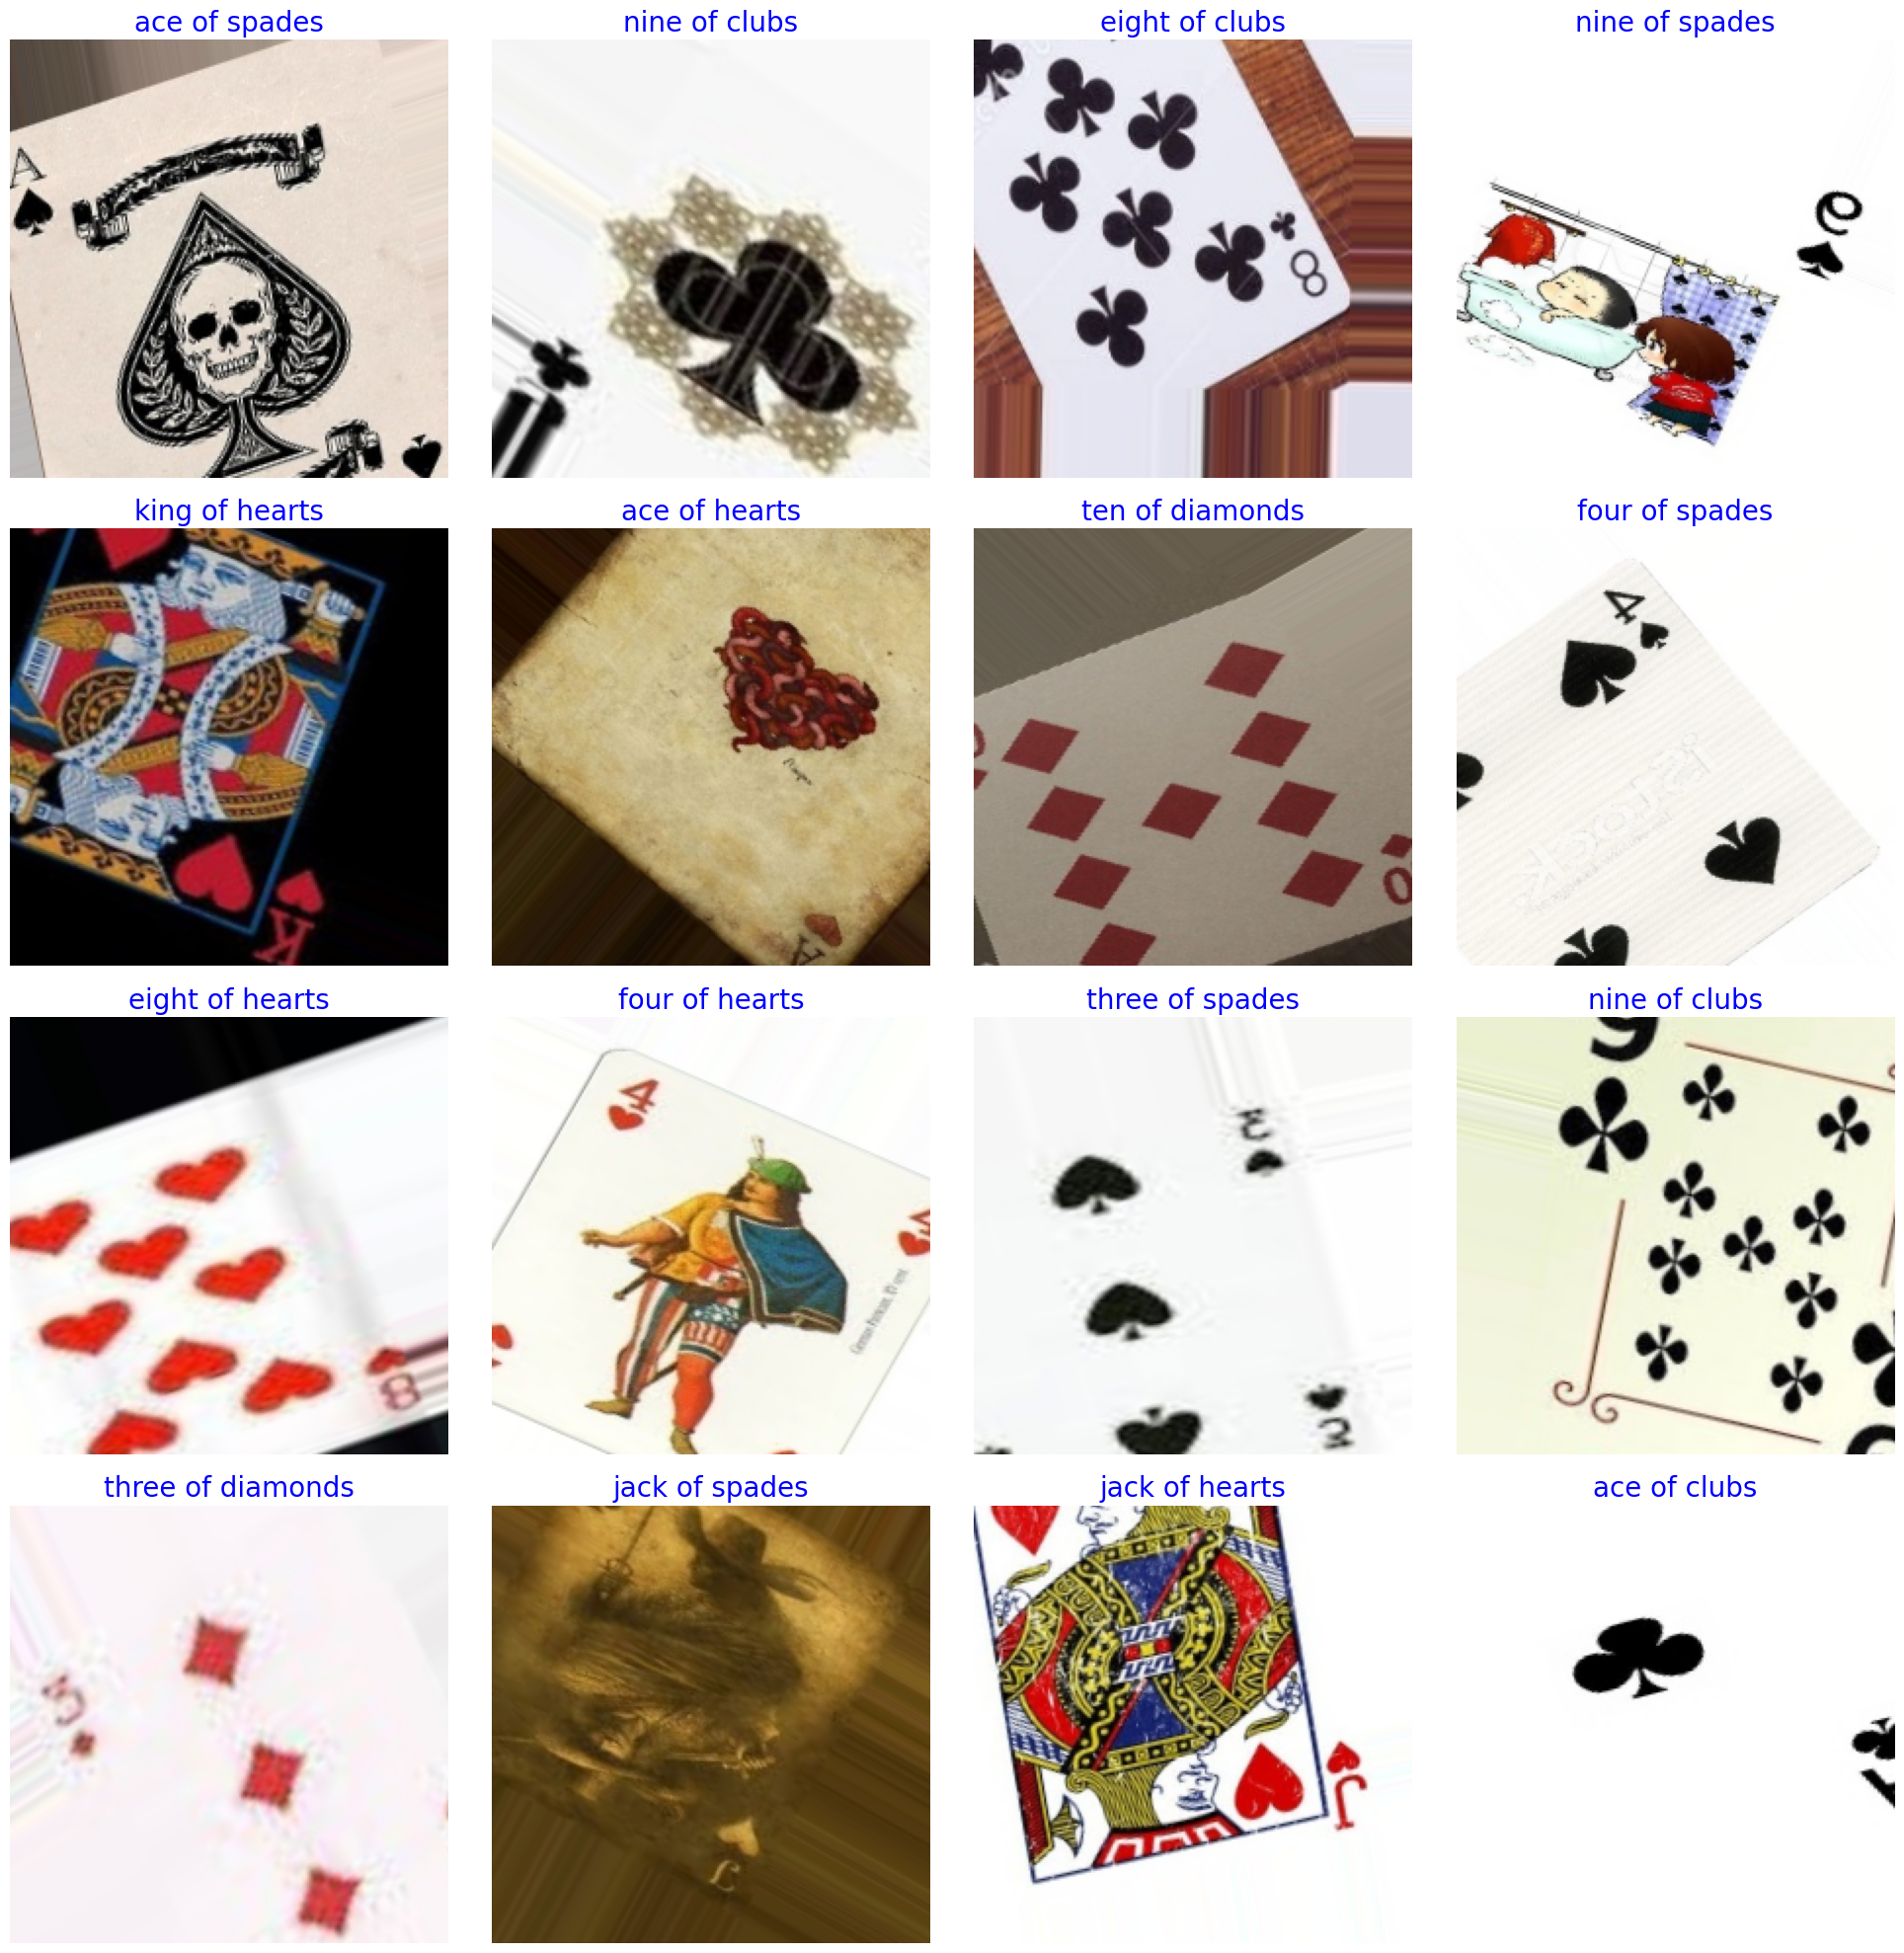

In [29]:
DataPreprocessing.show_sample_of_data(test_gen)

# Fine tuning Pretrained Model

In [30]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
)

base_model.trainable = True

In [31]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  814


In [32]:
inputs = keras.Input(image_shape)
x = base_model(inputs)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(rate=0.1, seed=123)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(rate=0.2, seed=123)(x)
outputs = keras.layers.Dense(class_count,activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [33]:
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 125440)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    16,056,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,165,836 (305.81 MB)

 Trainable params: 79,610,041 (303.69 MB)

 Non-trainable params: 555,795 (2.12 MB)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_gen, epochs= 50, verbose= 1,
                    validation_data = valid_gen, callbacks=[early_stopping], shuffle= False)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 652s 919ms/step - accuracy: 0.0383 - loss: 3.9603 - val_accuracy: 0.1585 - val_loss: 3.2723
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 136s 356ms/step - accuracy: 0.1575 - loss: 3.3524 - val_accuracy: 0.3925 - val_loss: 2.4399
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 136s 356ms/step - accuracy: 0.2782 - loss: 2.7547 - val_accuracy: 0.6075 - val_loss: 1.7343
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 136s 356ms/step - accuracy: 0.3923 - loss: 2.3124 - val_accuracy: 0.6717 - val_loss: 1.2917
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 137s 358ms/step - accuracy: 0.4920 - loss: 1.9183 - val_accuracy: 0.7547 - val_loss: 0.9838
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 136s 356ms/step - accuracy: 0.5718 - loss: 1.6411 - val_accuracy: 0.7660 - val_loss: 0.8375
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 137s 357ms/step - accuracy: 0.6244 - loss: 1.4080 - val_accuracy: 0.8189 - val_loss: 0.6739
Epoch 8/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 137s 357ms/step - accuracy: 0.6685 -

# Evaluate model

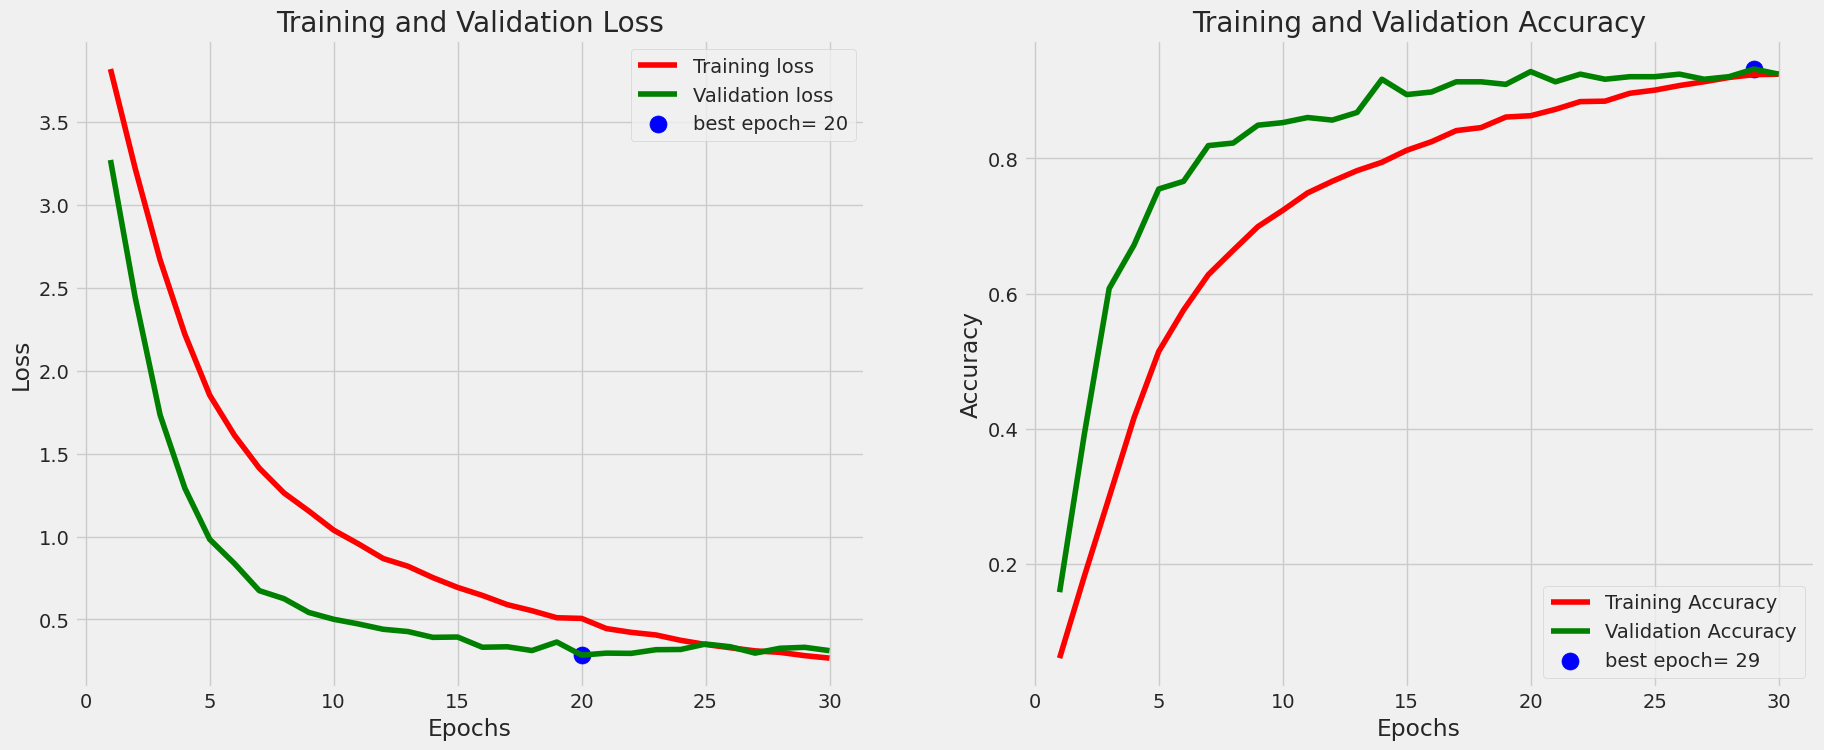

In [41]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [42]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

382/382 ━━━━━━━━━━━━━━━━━━━━ 92s 240ms/step - accuracy: 0.9559 - loss: 0.1830
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9062 - loss: 0.3934
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9147 - loss: 0.3435
Train Loss:  0.17771974205970764
Train Accuracy:  0.9568467736244202
--------------------
Validation Loss:  0.28511878848075867
Validation Accuracy:  0.9283018708229065
--------------------
Test Loss:  0.3675220310688019
Test Accuracy:  0.9056603908538818


# Get prediction

In [43]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


# Save the model

In [44]:
model.save('model.h5')